In [2]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from evaluator import Evaluator

env = gymnasium.make("Gym-Gridworlds/Penalty-3x3-v0", render_mode="human")
env.reset()

n_states = env.observation_space.n
n_actions = env.action_space.n

R = np.zeros((n_states, n_actions))
P = np.zeros((n_states, n_actions, n_states))
T = np.zeros((n_states, n_actions))

for s in range(n_states):
    for a in range(n_actions):
        env.unwrapped.set_state(s)
        s_next, r, terminated, _, _ = env.step(a)
        R[s, a] = r
        P[s, a, s_next] = 1.0
        T[s, a] = terminated

In [3]:
pi_opt = np.array([
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
])

In [32]:
import numpy as np
from typing import List
from typing import Tuple


class Evaluator:
    def __init__(self, env, initialization: int = 0, gamma: float = 0.99, threshold: float = 0.01) -> None:
        """
        Initializes the Evaluator class.

        Args:
            env: The environment object with observation and action spaces.
            initialization (int, optional): Initialization value for state and action values. Defaults to 0.
            gamma (float, optional): Discount factor for future rewards. Defaults to 0.99.
            threshold (float, optional): Threshold value for the stopping criterion. Defaults to 0.1.
        """
        self.n_states: int = env.observation_space.n
        self.n_actions: int = env.action_space.n
        self.initialization = initialization

        self.state_values: np.ndarray = np.zeros(self.n_states) + self.initialization
        self.q_values: np.ndarray = np.zeros((self.n_states, self.n_actions)) + self.initialization
        self.gamma: float = gamma
        self.threshold: float = threshold
        self.errors: List[float] = []


    def _reset(self) -> None:
        self.state_values: np.ndarray = np.zeros(self.n_states) + self.initialization
        self.q_values: np.ndarray = np.zeros((self.n_states, self.n_actions)) + self.initialization
        self.errors: List[float] = []


    def evaluate_state_values(self, policy: np.ndarray, R: np.ndarray, P: np.ndarray) -> None:
        """
        Evaluates state values using the provided policy.

        Args:
            policy (np.ndarray): The policy array where each entry policy[state] is a probability distribution over actions.
            R (np.ndarray): The reward array where R[state] is the reward for each state.
            P (np.ndarray): The transition probability array where P[state, action, next_state] represents the probability
                            of transitioning to next_state from state when taking action.

        Returns:
            None
        """
        delta: float = np.inf
        evaluation_errors = []
        while delta >= self.threshold:
            delta = 0.0
            iteration_error: float = 0.0
            for state in range(self.n_states):
                current_value = self.state_values[state]
                value = 0.0
                for action in range(self.n_actions):
                    for next_state in range(self.n_states):
                        value += policy[state, action] * P[state, action, next_state] * (R[state, action] + self.gamma * self.state_values[next_state])
                self.state_values[state] = value
                error = abs(current_value - self.state_values[state])
                delta = max(delta, error)
                iteration_error += error               
            evaluation_errors.append(iteration_error)
        self.errors.append(np.array(evaluation_errors))


    def policy_improvement(self, policy: np.ndarray, R: np.ndarray, P: np.ndarray) -> (np.ndarray, bool):
        is_policy_stable = True
        for state in range(self.n_states):
            old_policy = policy[state].copy()
            action_values = np.zeros(self.n_actions)
            for action in range(self.n_actions):
                action_value = 0.0
                for next_state in range(self.n_states):
                    action_value += P[state, action, next_state] * (R[state, action] + self.gamma * self.state_values[next_state])
                action_values[action] = action_value
            best_action = np.argmax(action_values)
            policy[state] = np.eye(self.n_actions)[best_action]  # One-hot encode the best action
            if not np.array_equal(old_policy, policy[state]):
                is_policy_stable = False

        return policy, is_policy_stable
    

    def policy_iteration(self, R: np.ndarray, P: np.ndarray) -> (np.ndarray, np.ndarray, int):
        self._reset()
        policy = np.ones((self.n_states, self.n_actions)) / self.n_actions
        is_policy_stable = False
        while not is_policy_stable:
            self.evaluate_state_values(policy=policy, R=R, P=P)
            policy, is_policy_stable = self.policy_improvement(policy=policy, R=R, P=P)
        return policy, np.array(self.errors, dtype=object)


    def value_iteration(self, R: np.ndarray, P: np.ndarray):
        delta: float = np.inf
        evaluation_errors = []
        while delta >= self.threshold:
            delta = 0.0
            iteration_error: float = 0.0
            for state in range(self.n_states):
                current_value = self.state_values[state]
                value = 0.0
                for action in range(self.n_actions):
                    for next_state in range(self.n_states):
                        value += policy[state, action] * P[state, action, next_state] * (R[state, action] + self.gamma * self.state_values[next_state])
                self.state_values[state] = value
                error = abs(current_value - self.state_values[state])
                delta = max(delta, error)
                iteration_error += error               
            evaluation_errors.append(iteration_error)
        self.errors.append(evaluation_errors)


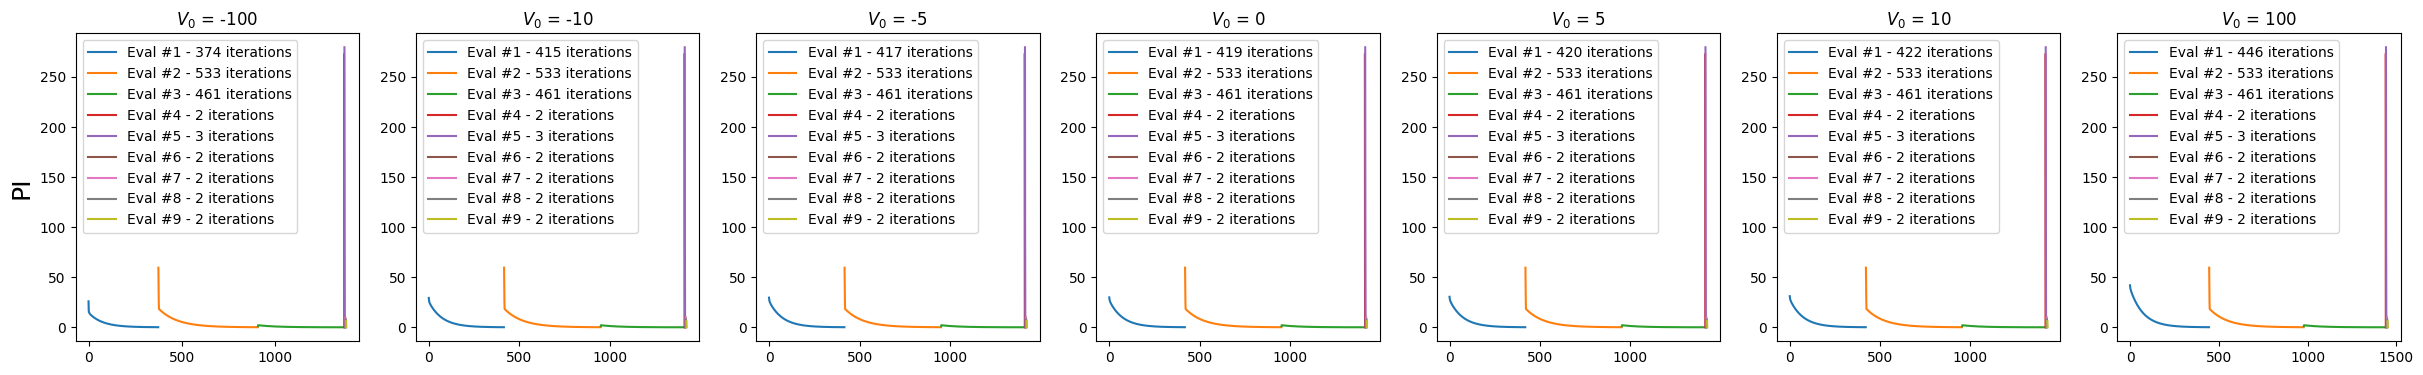

In [46]:
# fig, axs = plt.subplots(3, 7)
# tot_iter_table = np.zeros((3, 7))
fig, axs = plt.subplots(1, 7, figsize=(30, 4))
initializations = [-100, -10, -5, 0, 5, 10, 100]
tot_iter_table = pd.DataFrame([], index=['PI', 'VI', 'GPI'])
for i, init_value in enumerate(initializations):
    # axs[0][i].set_title(f'$V_0$ = {init_value}')
    axs[i].set_title(f'$V_0$ = {init_value}')

    x_offset = 0
    pi, be = Evaluator(env=env, gamma=0.99, initialization=init_value).policy_iteration(R=R, P=P)
    assert np.allclose(pi, pi_opt)
    for iteration_idx, data in enumerate(be):
        axs[i].plot(range(x_offset, x_offset + data.size), data, label=f'Eval #{iteration_idx+1} - {data.size} iterations')
        x_offset += data.size
        axs[i].legend()
    tot_iter_table.loc['PI', f"{init_value}"] = x_offset
    # axs[0][i].plot(be)

    # pi, tot_iter, be = policy_iteration(...)
    # tot_iter_table[1, i] = tot_iter
    # assert np.allclose(pi, pi_opt)
    # axs[1][i].plot(...)

    # pi, tot_iter, be = generalized_policy_iteration(...)
    # tot_iter_table[2, i] = tot_iter
    # assert np.allclose(pi, pi_opt)
    # axs[2][i].plot(...)

    if i == 0:
        axs[i].set_ylabel("PI", fontsize=18)
        # axs[0][i].set_ylabel("VI")
        # axs[1][i].set_ylabel("PI")
        # axs[2][i].set_ylabel("GPI")

plt.show()

In [42]:
tot_iter_table#.mean(axis=1)

,-100,-10,-5,0,5,10,100
PI,1381.0,1422.0,1424.0,1426.0,1427.0,1429.0,1453.0
VI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
